In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Introduction
We are interested in selecting the most appropriate ("best") variant caller for identifying SNPs and indels in microbial genomes. To do this in a principled manner, we constructed a pipeline to:
1. synthesize variants from a reference genome as our truth set for evaluating variant callers.
2. compare variant caller performance on different types of variants.


# Variant calling

In [3]:
def sum_filtered(df, filter_column, min_value, variantlog=None, logrow=2):
    '''
    df: from csv generated by testing pipeline, via checker.py
    filter_column: string of column name to filter by
    min_value: minimum threshold for values to retain when filtering by filter_column
    variantlog: variant output log generated by testing pipeline, via variants.py
    logrow: row to get total mutations from (0-start)
    '''
    sums = {}
    if filter_column == 'DP':
        filtered = df[(df[filter_column] >= min_value) | df[filter_column].isna() & (df['BAM_DP'] >= min_value)]
    else:
        filtered = df[(df[filter_column] >= min_value) | (df[filter_column].isna())]
    for tool in set(filtered['TOOL']):
        sums[tool] = [sum(filtered.loc[filtered['TOOL'] == tool, 'TRUE_POS']),
                      sum(filtered.loc[filtered['TOOL'] == tool, 'FALSE_POS']),
                      sum(filtered.loc[filtered['TOOL'] == tool, 'FALSE_NEG'])]
    filtered_sums = pd.DataFrame(data=sums).T
    filtered_sums.reset_index(inplace=True)
    filtered_sums.rename(columns={'index': 'caller', 0:'true_pos', 1:'false_pos', 2: 'false_neg'}, inplace=True)
    filtered_sums[filter_column] = min_value
    filtered_sums['recall'] = filtered_sums['true_pos'] / (filtered_sums['true_pos'] + filtered_sums['false_neg'])
    filtered_sums['precision'] = filtered_sums['true_pos'] / (filtered_sums['true_pos'] + filtered_sums['false_pos'])
    
    # Sanity check: When min_value = 0, introduced mutations == postfilter mutations
    if variantlog is not None:
        with open(variantlog, 'r') as log:
            varsettings = log.readlines()
        filtered_sums['total_mut_intro'] = int(varsettings[logrow].split(':')[-1].strip())
        filtered_sums['total_mut_postfilter'] = filtered_sums['true_pos'] + filtered_sums['false_neg']
    else:
        filtered_sums['total_mut_intro'] = np.nan
        filtered_sums['total_mut_postfilter'] = np.nan
    
    return filtered_sums

def combine_filtered(df, filter_column, filter_min, filter_max, filter_step, variantlog=None, logrow=2):
    filtered_dfs = []
    for threshold in range(filter_min, filter_max + filter_step, filter_step):
        summarydf = sum_filtered(df, filter_column, threshold, variantlog, logrow)
        filtered_dfs.append(summarydf)
    combined_summaries = pd.concat(filtered_dfs, ignore_index=True)
    return combined_summaries

In [4]:
# Called datasets
h37rv1000snp = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv10-3SNP_alltools_normalized_dp0_checked.csv')
h37rv1000ins = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv10-3INS_alltools_normalized_dp0_checked.csv')
h37rv1000del = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/H37Rv10-3DEL_alltools_normalized_dp0_checked.csv')

# Filter on BAM_DP
h37rv1000snp_summary = combine_filtered(h37rv1000snp, 'BAM_DP', 0, 70, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3SNP.log')
h37rv1000ins_summary = combine_filtered(h37rv1000ins, 'BAM_DP', 0, 100, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log')
h37rv1000dup_summary = combine_filtered(h37rv1000ins[h37rv1000ins.INS_TYPE == 'DUP'], 'BAM_DP', 0, 100, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log', 5)
h37rv1000rdm_summary = combine_filtered(h37rv1000ins[h37rv1000ins.INS_TYPE == 'RDM'], 'BAM_DP', 0, 60, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log', 6)
h37rv1000inv_summary = combine_filtered(h37rv1000ins[h37rv1000ins.INS_TYPE == 'INV'], 'BAM_DP', 0, 100, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log', 7)
h37rv1000del_summary = combine_filtered(h37rv1000del, 'BAM_DP', 0, 60, 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3DEL.log')

h37rv1000snp_summary['dataset'] = 'SNP'
h37rv1000ins_summary['dataset'] = 'INSERTION'
h37rv1000dup_summary['dataset'] = 'DUPLICATION'
h37rv1000rdm_summary['dataset'] = 'RANDOM SEQUENCE INSERTION'
h37rv1000inv_summary['dataset'] = 'INVERSION'
h37rv1000del_summary['dataset'] = 'DELETION'

In [5]:
# Filter on QUAL
h37rv1000snp_qual = combine_filtered(h37rv1000snp, 'QUAL', 0, 2400, 100, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3SNP.log')
h37rv1000ins_qual = combine_filtered(h37rv1000ins, 'QUAL', 0, 2500, 100, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log')
h37rv1000dup_qual = combine_filtered(h37rv1000ins[h37rv1000ins.INS_TYPE == 'DUP'], 'QUAL', 0, 2500, 100, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log', 5)
h37rv1000rdm_qual = combine_filtered(h37rv1000ins[h37rv1000ins.INS_TYPE == 'RDM'], 'QUAL', 0, 2400, 100, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log', 6)
h37rv1000inv_qual = combine_filtered(h37rv1000ins[h37rv1000ins.INS_TYPE == 'INV'], 'QUAL', 0, 2500, 100, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3INS.log', 7)
h37rv1000del_qual = combine_filtered(h37rv1000del, 'QUAL', 0, 2500, 100, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/H37Rv10-3DEL.log')

h37rv1000snp_qual['dataset'] = 'SNP'
h37rv1000ins_qual['dataset'] = 'INSERTION'
h37rv1000dup_qual['dataset'] = 'DUPLICATION'
h37rv1000rdm_qual['dataset'] = 'RANDOM SEQUENCE INSERTION'
h37rv1000inv_qual['dataset'] = 'INVERSION'
h37rv1000del_qual['dataset'] = 'DELETION'

In [26]:
all_datasets = pd.concat([h37rv1000snp, h37rv1000ins, h37rv1000del], ignore_index=True)

In [6]:
combined_df = pd.concat([h37rv1000snp_summary, h37rv1000ins_summary, h37rv1000del_summary], ignore_index=True)
combined_df2 = pd.concat([h37rv1000snp_summary, h37rv1000dup_summary, h37rv1000rdm_summary, h37rv1000inv_summary,
                         h37rv1000del_summary], ignore_index=True)
combined_df_qual = pd.concat([h37rv1000snp_qual, h37rv1000ins_qual, h37rv1000del_qual], ignore_index=True)
combined_df2_qual = pd.concat([h37rv1000snp_qual, h37rv1000dup_qual, h37rv1000rdm_qual, 
                               h37rv1000inv_qual, h37rv1000del_qual], ignore_index=True)

## Precision vs. Recall

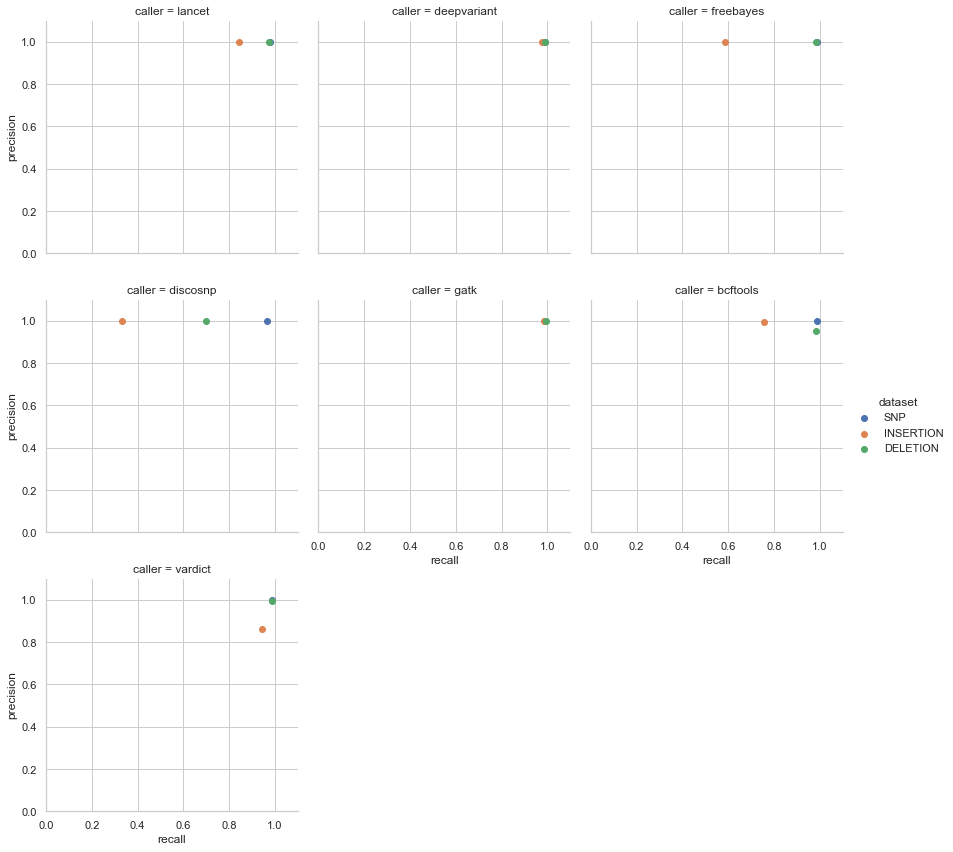

In [8]:
%matplotlib inline
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=combined_df[combined_df.BAM_DP == 0], hue='dataset', 
                   height=4, aspect=1, xlim=(0,1.1), ylim=(0,1.1),
                   col='caller', col_wrap=3)
fg.map(plt.scatter, 'recall', 'precision').add_legend()

## Filter by read depths (BAM_DP) 
### Total mutations

<AxesSubplot:xlabel='BAM_DP', ylabel='total_mut_postfilter'>

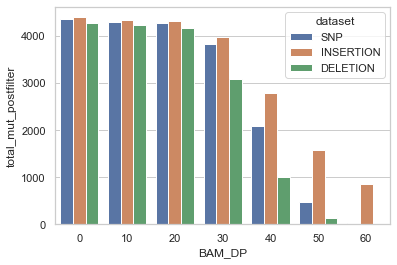

In [9]:
sns.barplot(data=combined_df[combined_df.BAM_DP <=60], x='BAM_DP', y='total_mut_postfilter', hue='dataset')

### Recall

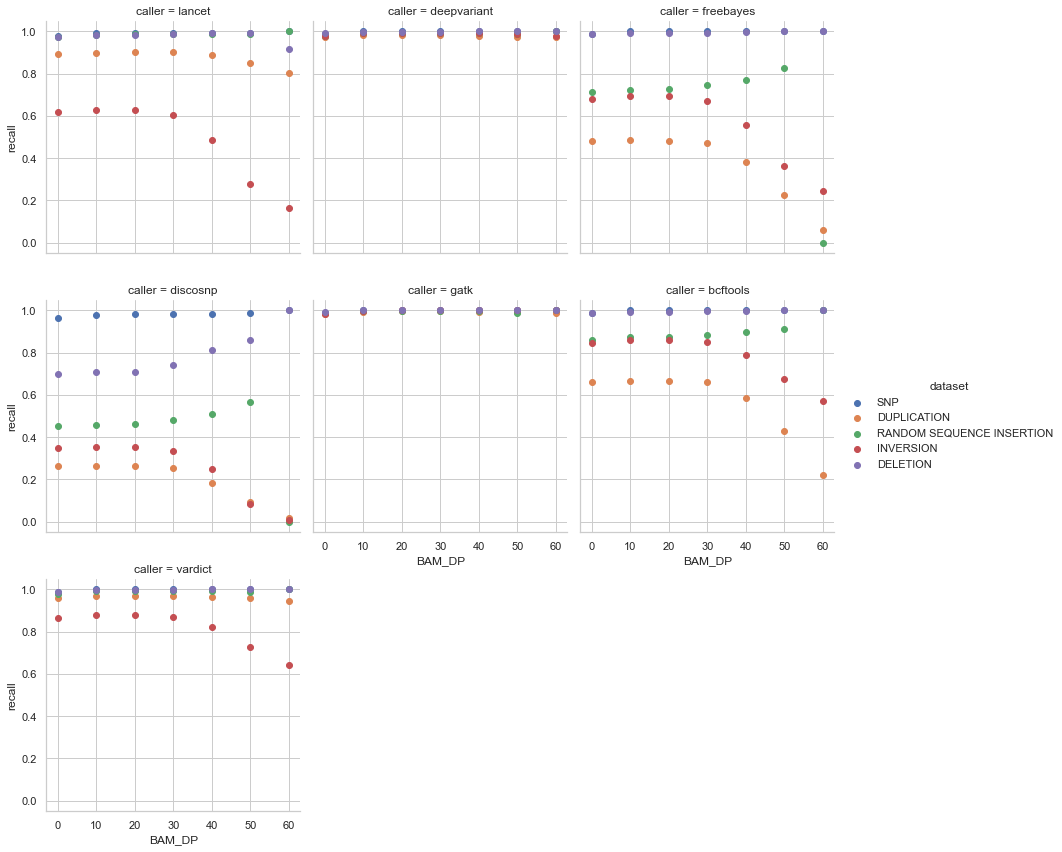

In [10]:
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=combined_df2[combined_df2.BAM_DP <=60], hue='dataset', height=4, aspect=1,
                   col='caller', col_wrap=3)
fg.map(plt.scatter, 'BAM_DP', 'recall').add_legend()

### Precision

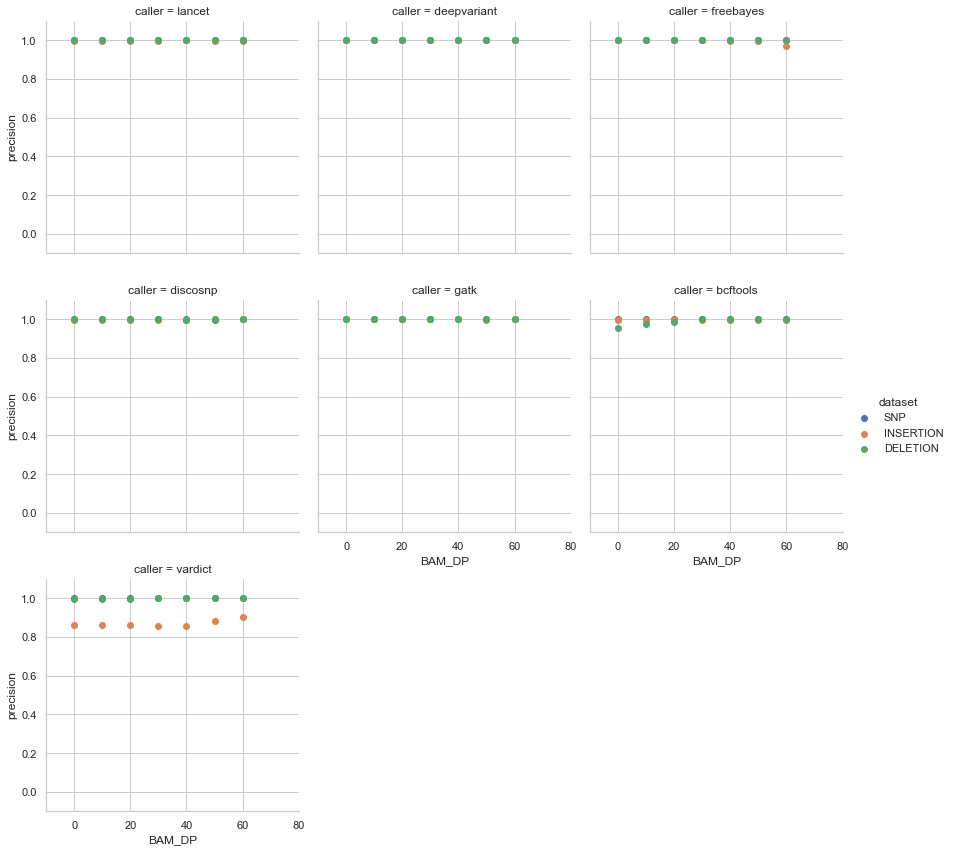

In [11]:
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=combined_df[combined_df.BAM_DP <= 60], hue='dataset', height=4, aspect=1,
                   xlim=(-10,80), ylim=(-0.1,1.1),
                   col='caller', col_wrap=3)
fg.map(plt.scatter, 'BAM_DP', 'precision').add_legend()

## Filter by QUAL
**Notes:** 
- DiscoSNP reports `.` in its VCF QUAL column.
- QUAL ranges differ by orders of magnitude between variant callers.

In [94]:
# QUAL ranges by variant caller
for tool in set(all_datasets['TOOL']):
    print(tool, 'QUAL:', min(all_datasets[all_datasets.TOOL == tool].QUAL), '-', max(all_datasets[all_datasets.TOOL == tool].QUAL))

lancet QUAL: 13.48 - 289.42
deepvariant QUAL: 3.0 - 69.8
freebayes QUAL: 1.23 - 2417.4
discosnp QUAL: nan - nan
gatk QUAL: 50.0 - 2797.97
bcftools QUAL: 3.22 - 228.43
vardict QUAL: 34.0 - 232.0


### Total mutations

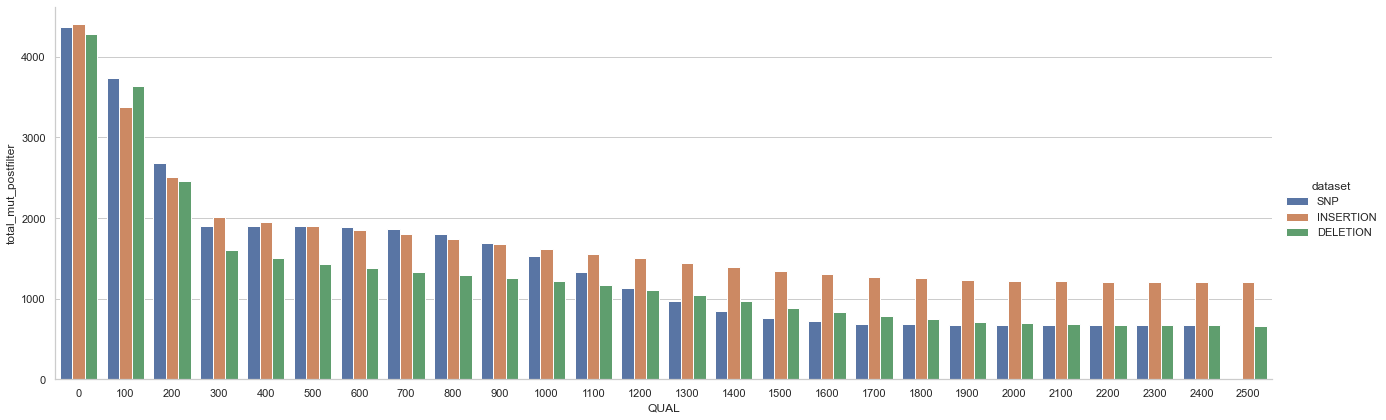

In [12]:
sns.catplot(data=combined_df_qual, x='QUAL', y='total_mut_postfilter', hue='dataset', kind='bar', ci=None, height=6, aspect=3)

### Recall

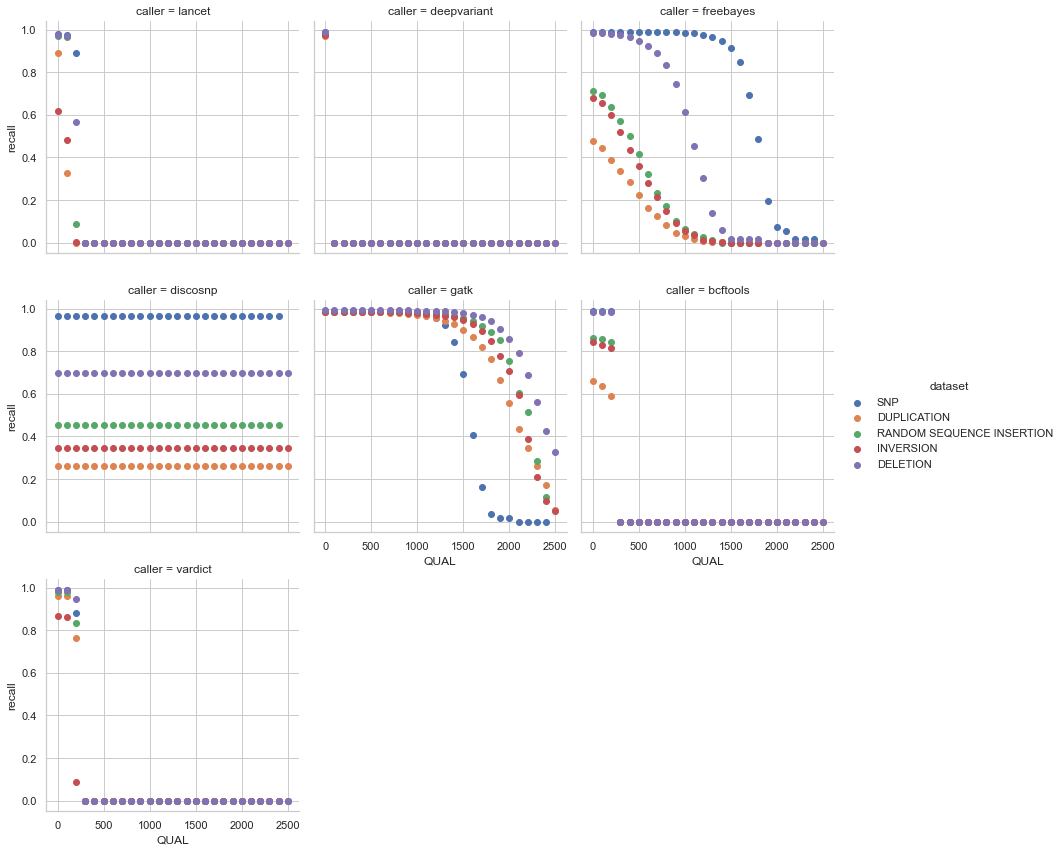

In [13]:
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=combined_df2_qual, hue='dataset', height=4, aspect=1,
                   col='caller', col_wrap=3, sharex=True)
fg.map(plt.scatter, 'QUAL', 'recall').add_legend()

### Precision

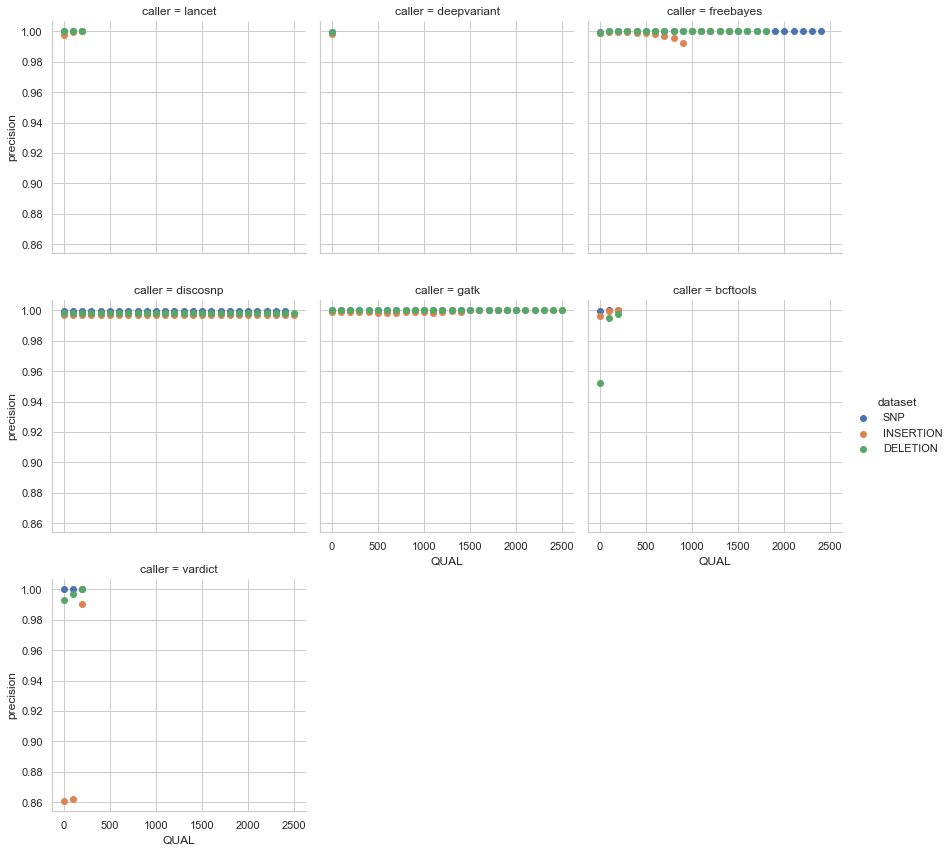

In [14]:
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=combined_df_qual, hue='dataset', height=4, aspect=1,
                   col='caller', col_wrap=3, sharex=True)
fg.map(plt.scatter, 'QUAL', 'precision').add_legend()

## QUAL ranges for TP and FP calls
See [related comment here](https://gitlab.labmed.uw.edu/molmicro/mtb_amr/-/issues/67#note_65502).

**Summary:** 

There are few FP calls for most of the variant callers (i.e., precision is high). While FP calls tend to have lower QUAL scores than TP calls, troughs between TP and FP QUAL scores are not easy to distinguish, for two reasons: few FP calls, and FP calls with high QUALs. Exceptions are seen in bcftools (SNP-only dataset) and VarDict (INS-only dataset); both have more FP calls with lower QUALs.

### GATK
- Orange: TP calls
- Blue: FP or FN calls

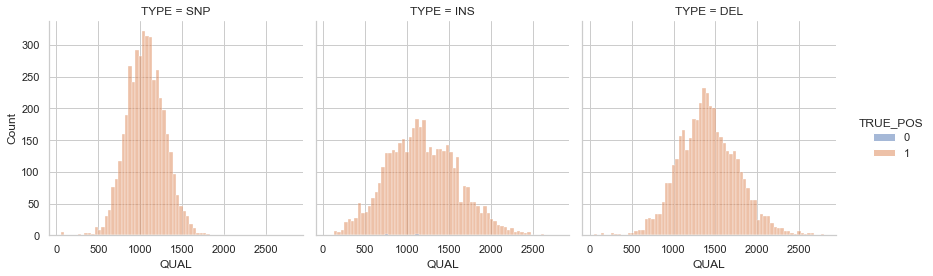

In [60]:
sns.displot(data=all_datasets[all_datasets.TOOL == 'gatk'], height=4, aspect=1, col='TYPE', x='QUAL', hue='TRUE_POS')

### GATK (False Positives only)

(0.0, 2500.0)

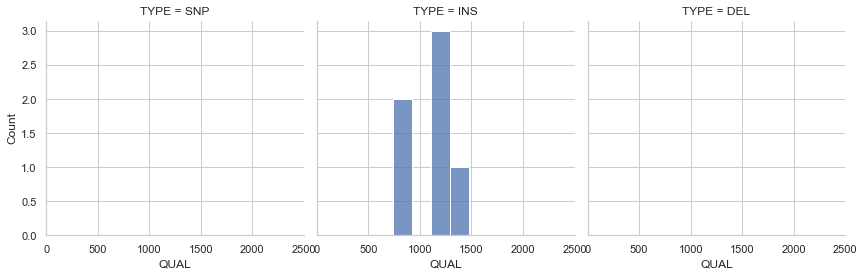

In [79]:
sns.displot(data=all_datasets[(all_datasets.TOOL == 'gatk') & (all_datasets.FALSE_POS == 1)], 
            height=4, aspect=1, col='TYPE', col_order=['SNP', 'INS', 'DEL'], x='QUAL')
plt.xlim(0,2500)

In [85]:
all_datasets[(all_datasets.TOOL == 'gatk') & (all_datasets.FALSE_POS == 1)]

,CHROM,POS,REF,ALT,TYPE,INS_TYPE,MQ,LEN,QUAL,AD_REF,...,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
31651,NC_000962.3,1097246,G,GCGAAGTCAACCGTGAGGTTCTCCGACCTGACGCTGGACCCGGTAA...,INS,NaN,60.00,51,1209.97,0.0,...,13.0,35,1,hom,NaN,gatk,H37Rv10-3INS,0,1,0
31749,NC_000962.3,1194924,T,TGCAGCGCTCCCCAATGTCCGGGTCATCGTCCAGTTCGGTTGCAGC...,INS,NaN,59.10,55,1130.97,0.0,...,12.0,52,1,hom,NaN,gatk,H37Rv10-3INS,0,1,0
32377,NC_000962.3,1790573,T,TGTTCGCCTCCCCGGTGGATTGCCATTTCTGCTCGCAATCGGGGCT...,INS,NaN,60.00,72,738.97,0.0,...,10.0,58,1,hom,NaN,gatk,H37Rv10-3INS,0,1,0
32826,NC_000962.3,2242624,G,GAACC,INS,NaN,59.66,4,751.97,0.0,...,18.0,37,1,hom,NaN,gatk,H37Rv10-3INS,0,1,0
32827,NC_000962.3,2242625,T,TGTTCGTCGTCGTCGAGGCGTTCTATCTGTATAA,INS,NaN,59.75,33,1471.97,0.0,...,18.0,35,1,hom,NaN,gatk,H37Rv10-3INS,0,1,0
34141,NC_000962.3,3579809,G,GCCAGCAGTTCCTGGCGGCCGGTCCGTCTTCGGCGTCCCCGGCCAG...,INS,NaN,59.48,53,1140.97,0.0,...,10.0,62,1,hom,NaN,gatk,H37Rv10-3INS,0,1,0


### FreeBayes
- Orange: TP calls
- Blue: FP or FN calls

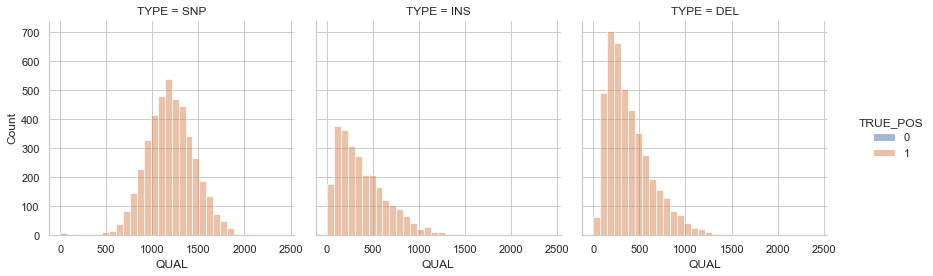

In [63]:
sns.displot(data=all_datasets[all_datasets.TOOL == 'freebayes'], height=4, aspect=1, col='TYPE', x='QUAL', hue='TRUE_POS')

### FreeBayes (False Positives only)

(0.0, 2500.0)

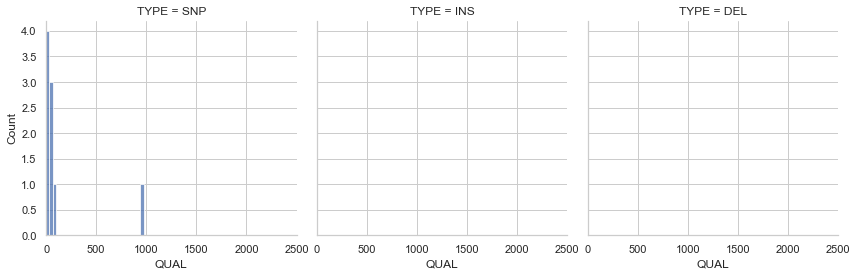

In [80]:
sns.displot(data=all_datasets[(all_datasets.TOOL == 'freebayes') & (all_datasets.FALSE_POS == 1)], 
            height=4, aspect=1, col='TYPE', col_order=['SNP', 'INS', 'DEL'], x='QUAL')
plt.xlim(0,2500)

In [86]:
all_datasets[(all_datasets.TOOL == 'freebayes') & (all_datasets.FALSE_POS == 1)]

,CHROM,POS,REF,ALT,TYPE,INS_TYPE,MQ,LEN,QUAL,AD_REF,...,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
9562,NC_000962.3,845281,C,T,SNP,NaN,60.0000,1,24.07,0.0,...,2.0,2,1,hom,NaN,freebayes,H37Rv10-3SNP,0,1,0
12820,NC_000962.3,4147176,C,A,SNP,NaN,60.0000,1,5.26,2.0,...,5.0,6,1,hom,NaN,freebayes,H37Rv10-3SNP,0,1,0
39525,NC_000962.3,150731,G,A,SNP,NaN,59.8462,1,972.66,19.0,...,71.0,79,1,hom,NaN,freebayes,H37Rv10-3INS,0,1,0
41935,NC_000962.3,2529056,A,C,SNP,NaN,59.9655,1,1.23,28.0,...,57.0,70,1,hom,NaN,freebayes,H37Rv10-3INS,0,1,0
42545,NC_000962.3,3163049,G,T,SNP,NaN,60.0000,1,58.66,34.0,...,72.0,72,1,hom,NaN,freebayes,H37Rv10-3INS,0,1,0
71888,NC_000962.3,1052077,C,A,SNP,NaN,60.0000,1,26.59,0.0,...,2.0,2,1,hom,NaN,freebayes,H37Rv10-3DEL,0,1,0
72445,NC_000962.3,1641139,C,G,SNP,NaN,60.0000,1,46.52,0.0,...,2.0,2,1,hom,NaN,freebayes,H37Rv10-3DEL,0,1,0
72446,NC_000962.3,1641184,G,A,SNP,NaN,60.0000,1,47.46,0.0,...,2.0,20,1,hom,NaN,freebayes,H37Rv10-3DEL,0,1,0
74001,NC_000962.3,3229597,T,A,SNP,NaN,60.0000,1,85.04,0.0,...,4.0,2,1,hom,NaN,freebayes,H37Rv10-3DEL,0,1,0


### DeepVariant
- Orange: TP calls
- Blue: FP or FN calls

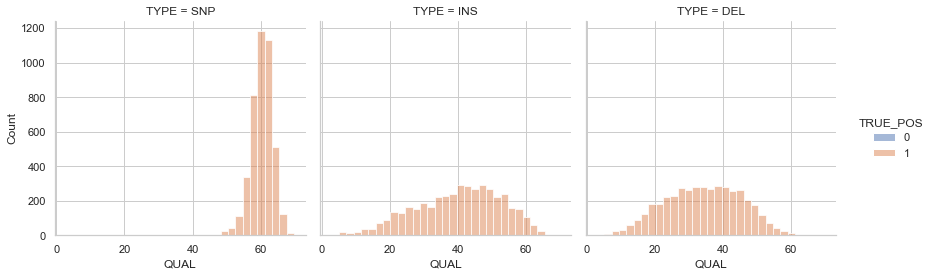

In [64]:
sns.displot(data=all_datasets[all_datasets.TOOL == 'deepvariant'], height=4, aspect=1, col='TYPE', x='QUAL', hue='TRUE_POS')

### DeepVariant (False Positives only)

(0.0, 70.0)

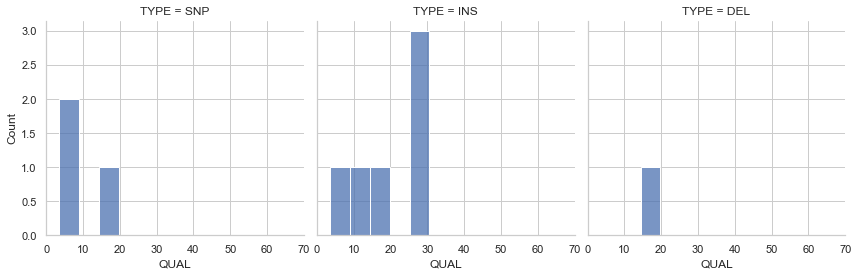

In [81]:
sns.displot(data=all_datasets[(all_datasets.TOOL == 'deepvariant') & (all_datasets.FALSE_POS == 1)], 
            height=4, aspect=1, col='TYPE', col_order=['SNP', 'INS', 'DEL'], x='QUAL')
plt.xlim(0,70)

In [87]:
all_datasets[(all_datasets.TOOL == 'deepvariant') & (all_datasets.FALSE_POS == 1)]

,CHROM,POS,REF,ALT,TYPE,INS_TYPE,MQ,LEN,QUAL,AD_REF,...,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
13928,NC_000962.3,845281,C,T,SNP,NaN,NaN,1,8.0,0.0,...,2.0,2,1/1,hom,NaN,deepvariant,H37Rv10-3SNP,0,1,0
17186,NC_000962.3,4147176,C,A,SNP,NaN,NaN,1,15.7,2.0,...,5.0,6,0/1,het,NaN,deepvariant,H37Rv10-3SNP,0,1,0
44875,NC_000962.3,1097246,G,GCGAAGTCAACCGTGAGGTTCTCCGACCTGACGCTGGACCCGGTAA...,INS,NaN,NaN,51,18.7,1.0,...,38.0,35,1/1,hom,NaN,deepvariant,H37Rv10-3INS,0,1,0
44973,NC_000962.3,1194924,T,TGCAGCGCTCCCCAATGTCCGGGTCATCGTCCAGTTCGGTTGCAGC...,INS,NaN,NaN,55,7.2,0.0,...,65.0,52,1/1,hom,NaN,deepvariant,H37Rv10-3INS,0,1,0
45056,NC_000962.3,1276511,G,GGCGACGCCCCGGCCTACCACAGTGAGGTCCACCACGTAACGCCGT...,INS,NaN,NaN,97,27.2,1.0,...,28.0,20,1/2,het,NaN,deepvariant,H37Rv10-3INS,0,1,0
46050,NC_000962.3,2242624,G,GAACC,INS,NaN,NaN,4,30.6,0.0,...,39.0,37,1/1,hom,NaN,deepvariant,H37Rv10-3INS,0,1,0
46051,NC_000962.3,2242625,T,TGTTCGTCGTCGTCGAGGCGTTCTATCTGTATAA,INS,NaN,NaN,33,25.6,0.0,...,48.0,35,1/1,hom,NaN,deepvariant,H37Rv10-3INS,0,1,0
46960,NC_000962.3,3171512,ATCGGACACAGGCG,A,DEL,NaN,NaN,13,18.8,12.0,...,28.0,30,0/1,het,NaN,deepvariant,H37Rv10-3INS,0,1,0
47366,NC_000962.3,3579809,G,GCCAGCAGTTCCTGGCGGCCGGTCCGTCTTCGGCGTCCCCGGCCAG...,INS,NaN,NaN,53,9.0,0.0,...,69.0,62,1/1,hom,NaN,deepvariant,H37Rv10-3INS,0,1,0
76936,NC_000962.3,1848632,T,A,SNP,NaN,NaN,1,3.6,0.0,...,9.0,9,1/1,hom,NaN,deepvariant,H37Rv10-3DEL,0,1,0


### bcftools
- Orange: TP calls
- Blue: FP or FN calls

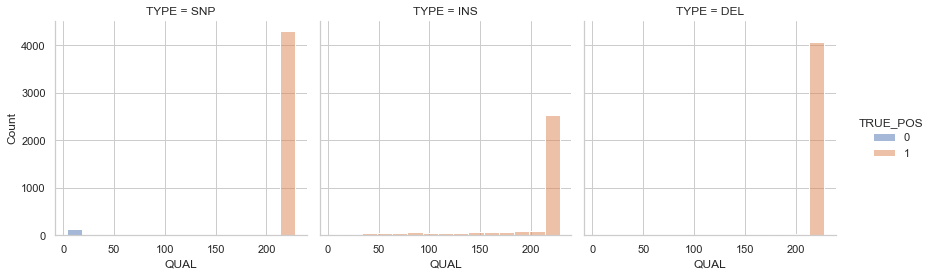

In [61]:
sns.displot(data=all_datasets[all_datasets.TOOL == 'bcftools'], height=4, aspect=1, col='TYPE', x='QUAL', hue='TRUE_POS')

### bcftools (False Positives only)

(0.0, 250.0)

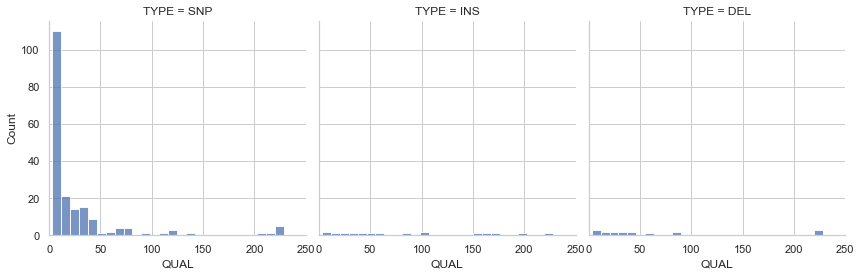

In [82]:
sns.displot(data=all_datasets[(all_datasets.TOOL == 'bcftools') & (all_datasets.FALSE_POS == 1)], 
            height=4, aspect=1, col='TYPE', col_order=['SNP', 'INS', 'DEL'], x='QUAL')
plt.xlim(0,250)

In [88]:
all_datasets[(all_datasets.TOOL == 'bcftools') & (all_datasets.FALSE_POS == 1)]

,CHROM,POS,REF,ALT,TYPE,INS_TYPE,MQ,LEN,QUAL,AD_REF,...,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
5197,NC_000962.3,845281,C,T,SNP,NaN,60.0,1,3.78,0.0,...,2.0,2,1,hom,NaN,bcftools,H37Rv10-3SNP,0,1,0
35112,NC_000962.3,150731,G,A,SNP,NaN,58.0,1,28.82,11.0,...,40.0,71,1,hom,NaN,bcftools,H37Rv10-3INS,0,1,0
35201,NC_000962.3,237703,C,CTG,INS,NaN,46.0,2,85.42,0.0,...,3.0,33,1,hom,NaN,bcftools,H37Rv10-3INS,0,1,0
35736,NC_000962.3,772131,G,GTACGGACAGCACGTTCCTGTTCATGCAGGAGTCTGTAGAGTGAT,INS,NaN,60.0,44,43.41,0.0,...,2.0,39,1,hom,NaN,bcftools,H37Rv10-3INS,0,1,0
35800,NC_000962.3,840560,GC,G,DEL,NaN,60.0,1,10.67,27.0,...,50.0,52,1,hom,NaN,bcftools,H37Rv10-3INS,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70605,NC_000962.3,4157300,T,C,SNP,NaN,60.0,1,9.00,0.0,...,2.0,14,1,hom,NaN,bcftools,H37Rv10-3DEL,0,1,0
70640,NC_000962.3,4193850,A,G,SNP,NaN,60.0,1,9.00,0.0,...,1.0,1,1,hom,NaN,bcftools,H37Rv10-3DEL,0,1,0
70678,NC_000962.3,4231888,A,C,SNP,NaN,60.0,1,225.42,0.0,...,14.0,16,1,hom,NaN,bcftools,H37Rv10-3DEL,0,1,0
70686,NC_000962.3,4239481,T,C,SNP,NaN,60.0,1,5.76,0.0,...,1.0,16,1,hom,NaN,bcftools,H37Rv10-3DEL,0,1,0


### Lancet
- Orange: TP calls
- Blue: FP or FN calls

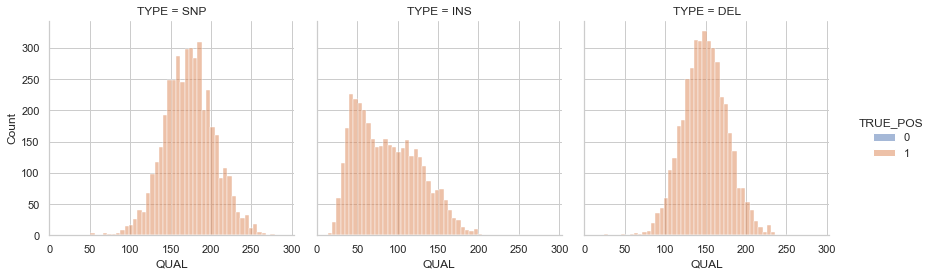

In [65]:
sns.displot(data=all_datasets[all_datasets.TOOL == 'lancet'], height=4, aspect=1, col='TYPE', x='QUAL', hue='TRUE_POS')

### Lancet (False Positives only)

(0.0, 300.0)

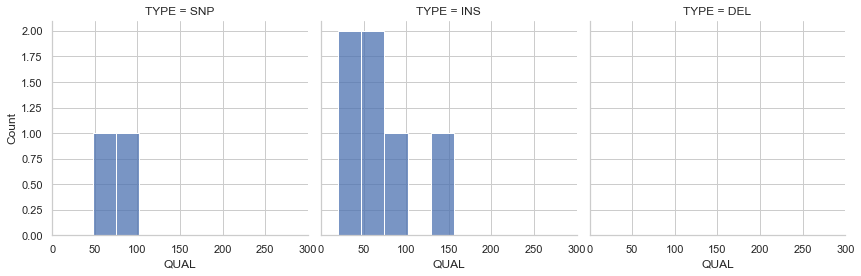

In [83]:
sns.displot(data=all_datasets[(all_datasets.TOOL == 'lancet') & (all_datasets.FALSE_POS == 1)], 
            height=4, aspect=1, col='TYPE', col_order=['SNP', 'INS', 'DEL'], x='QUAL')
plt.xlim(0,300)

In [89]:
all_datasets[(all_datasets.TOOL == 'lancet') & (all_datasets.FALSE_POS == 1)]

,CHROM,POS,REF,ALT,TYPE,INS_TYPE,MQ,LEN,QUAL,AD_REF,...,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
52945,NC_000962.3,354412,C,A,SNP,NaN,NaN,1,53.39,25.0,...,53.0,33,0/1,het,NaN,lancet,H37Rv10-3INS,0,1,0
53016,NC_000962.3,419729,C,CATTCAGCGCTGAGCCT,INS,NaN,NaN,16,20.19,4.0,...,7.0,59,0/1,het,NaN,lancet,H37Rv10-3INS,0,1,0
53626,NC_000962.3,1038048,C,G,SNP,NaN,NaN,1,88.14,18.0,...,42.0,25,0/1,het,NaN,lancet,H37Rv10-3INS,0,1,0
53691,NC_000962.3,1097246,G,GCGAAGTCAACCGTGAGGTTCTCCGACCTGACGCTGGACCCGGTAA...,INS,NaN,NaN,51,60.55,6.0,...,18.0,35,0/1,het,NaN,lancet,H37Rv10-3INS,0,1,0
53789,NC_000962.3,1194924,T,TGCAGCGCTCCCCAATGTCCGGGTCATCGTCCAGTTCGGTTGCAGC...,INS,NaN,NaN,55,61.39,10.0,...,32.0,52,0/1,het,NaN,lancet,H37Rv10-3INS,0,1,0
54417,NC_000962.3,1790573,T,TGTTCGCCTCCCCGGTGGATTGCCATTTCTGCTCGCAATCGGGGCT...,INS,NaN,NaN,72,40.73,9.0,...,23.0,58,0/1,het,NaN,lancet,H37Rv10-3INS,0,1,0
54866,NC_000962.3,2242625,T,AACCTGTTCGTCGTCGTCGAGGCGTTCTATCTGTATAA,INS,NaN,NaN,37,156.22,0.0,...,20.0,36,1/1,hom,NaN,lancet,H37Rv10-3INS,0,1,0
56180,NC_000962.3,3579809,G,GCCAGCAGTTCCTGGCGGCCGGTCCGTCTTCGGCGTCCCCGGCCAG...,INS,NaN,NaN,53,77.55,7.0,...,29.0,62,0/1,het,NaN,lancet,H37Rv10-3INS,0,1,0


### VarDict
- Orange: TP calls
- Blue: FP or FN calls

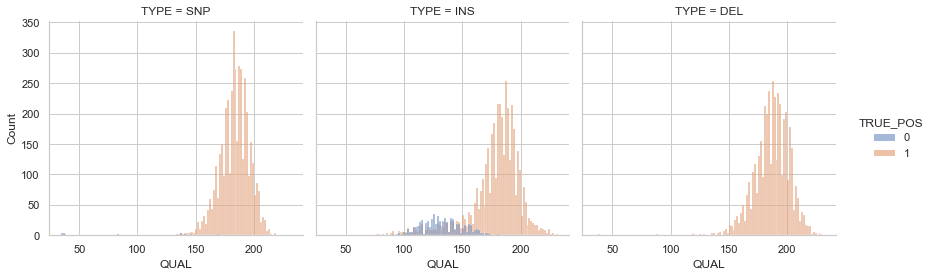

In [66]:
sns.displot(data=all_datasets[all_datasets.TOOL == 'vardict'], height=4, aspect=1, col='TYPE', x='QUAL', hue='TRUE_POS')

### VarDict (False Positives only)

(0.0, 250.0)

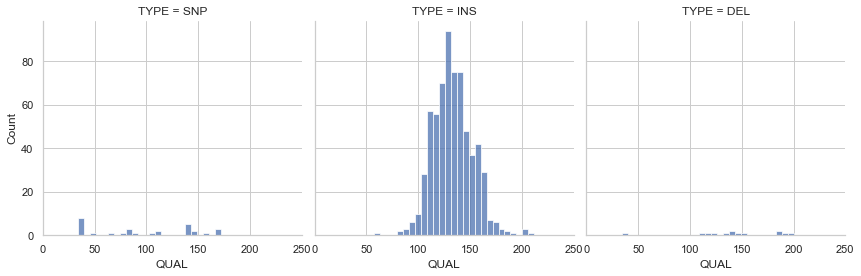

In [78]:
sns.displot(data=all_datasets[(all_datasets.TOOL == 'vardict') & (all_datasets.FALSE_POS == 1)], 
            height=4, aspect=1, col='TYPE', col_order=['SNP', 'INS', 'DEL'], x='QUAL')
plt.xlim(0,250)

In [90]:
all_datasets[(all_datasets.TOOL == 'vardict') & (all_datasets.FALSE_POS == 1)]

,CHROM,POS,REF,ALT,TYPE,INS_TYPE,MQ,LEN,QUAL,AD_REF,...,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
57004,NC_000962.3,1366,G,GATCTTTCGTTGCCCAAAATCGACCA,INS,NaN,60.0,25,139.0,28.0,...,46.0,45,0/1,het,NaN,vardict,H37Rv10-3INS,0,1,0
57005,NC_000962.3,1373,C,CGTTGCCCAAAATCGACCGATCTTTA,INS,NaN,60.0,25,134.0,31.0,...,47.0,42,0/1,het,NaN,vardict,H37Rv10-3INS,0,1,0
57009,NC_000962.3,4866,C,CTTGAGGATCATGCAGGCCCAGCTTA,INS,NaN,60.0,25,145.0,39.0,...,61.0,47,0/1,het,NaN,vardict,H37Rv10-3INS,0,1,0
57011,NC_000962.3,5524,C,CTCCGGCATACCGACA,INS,NaN,60.0,15,112.0,23.0,...,34.0,25,0/1,het,NaN,vardict,H37Rv10-3INS,0,1,0
57020,NC_000962.3,14015,C,CGGGACTACCTCGACAAGGGGATCTGGA,INS,NaN,60.0,27,145.0,22.0,...,41.0,34,0/1,het,NaN,vardict,H37Rv10-3INS,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91658,NC_000962.3,3736318,G,GCTC,INS,NaN,60.0,3,95.0,0.0,...,7.0,22,1/1,hom,NaN,vardict,H37Rv10-3DEL,0,1,0
91854,NC_000962.3,3934744,CCGGC,GCGCCGGCGCCG,INS,NaN,60.0,7,115.0,0.0,...,12.0,13,1/1,hom,NaN,vardict,H37Rv10-3DEL,0,1,0
91862,NC_000962.3,3942653,C,T,SNP,NaN,60.0,1,50.0,0.0,...,3.0,18,1/1,hom,NaN,vardict,H37Rv10-3DEL,0,1,0
91865,NC_000962.3,3945634,A,G,SNP,NaN,60.0,1,34.0,0.0,...,7.0,14,0/1,het,NaN,vardict,H37Rv10-3DEL,0,1,0


## In-house sequenced reads (H37Ra mapped to H37Rv)

In [15]:
h37ra_toRv = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/sequenced/output/checked/sub1089-710-517_alltools_normalized_dp0_checked.csv')

In [16]:
h37ra_toRv_summary = combine_filtered(h37ra_toRv, 'BAM_DP', 0, 100, 10)

In [17]:
h37ra_toRv

,CHROM,POS,REF,ALT,TYPE,INS_TYPE,LEN,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
0,NC_000962.3,14785,T,C,SNP,NaN,1,2414.0,0.0,80.0,80.0,88,1,hom,NaN,gatk,sub1089-710-517,1,0,0
1,NC_000962.3,17903,G,A,SNP,NaN,1,1369.0,0.0,51.0,51.0,58,1,hom,NaN,gatk,sub1089-710-517,1,0,0
2,NC_000962.3,42417,T,C,SNP,NaN,1,1457.0,0.0,52.0,52.0,56,1,hom,NaN,gatk,sub1089-710-517,1,0,0
3,NC_000962.3,55553,C,T,SNP,NaN,1,1736.0,2.0,64.0,66.0,75,1,hom,NaN,gatk,sub1089-710-517,1,0,0
4,NC_000962.3,69989,G,A,SNP,NaN,1,2539.0,0.0,78.0,78.0,89,1,hom,NaN,gatk,sub1089-710-517,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,NC_000962.3,4095001,CG,C,INDEL,NaN,1,183.0,0.0,42.0,42.0,43,1/1,hom,NaN,vardict,sub1089-710-517,1,0,0
889,NC_000962.3,4100975,T,C,SNP,NaN,1,192.0,0.0,63.0,64.0,68,1/1,hom,NaN,vardict,sub1089-710-517,1,0,0
890,NC_000962.3,4337243,C,INV,INS,NaN,2,35.0,0.0,2.0,2.0,67,1/1,hom,NaN,vardict,sub1089-710-517,0,1,0
891,NC_000962.3,4359099,G,C,SNP,NaN,1,209.0,0.0,72.0,72.0,75,1/1,hom,NaN,vardict,sub1089-710-517,1,0,0


In [18]:
h37ra_toRv_summary

,caller,true_pos,false_pos,false_neg,BAM_DP,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,86,42,27,0,0.761062,0.671875,NaN,NaN
1,deepvariant,105,8,8,0,0.929204,0.929204,NaN,NaN
2,freebayes,99,10,14,0,0.876106,0.908257,NaN,NaN
3,discosnp,52,2,61,0,0.460177,0.962963,NaN,NaN
4,gatk,103,13,10,0,0.911504,0.887931,NaN,NaN
...,...,...,...,...,...,...,...,...,...
66,discosnp,2,0,0,90,1.000000,1.000000,NaN,NaN
67,gatk,2,0,0,90,1.000000,1.000000,NaN,NaN
68,bcftools,2,0,0,90,1.000000,1.000000,NaN,NaN
69,vardict,2,1,0,90,1.000000,0.666667,NaN,NaN


### Precision vs. Recall (H37Ra mapped to H37Rv)

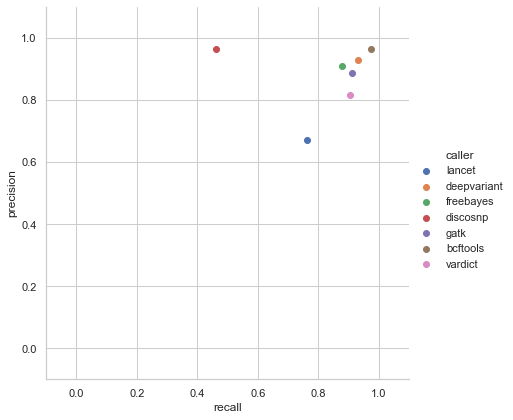

In [19]:
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=h37ra_toRv_summary[h37ra_toRv_summary.BAM_DP == 0], hue='caller', 
                   height=6, aspect=1, xlim=(-0.1,1.1), ylim=(-0.1,1.1))
fg.map(plt.scatter, 'recall', 'precision').add_legend()

### Recall, precision vs. read depth filtering (BAM_DP)

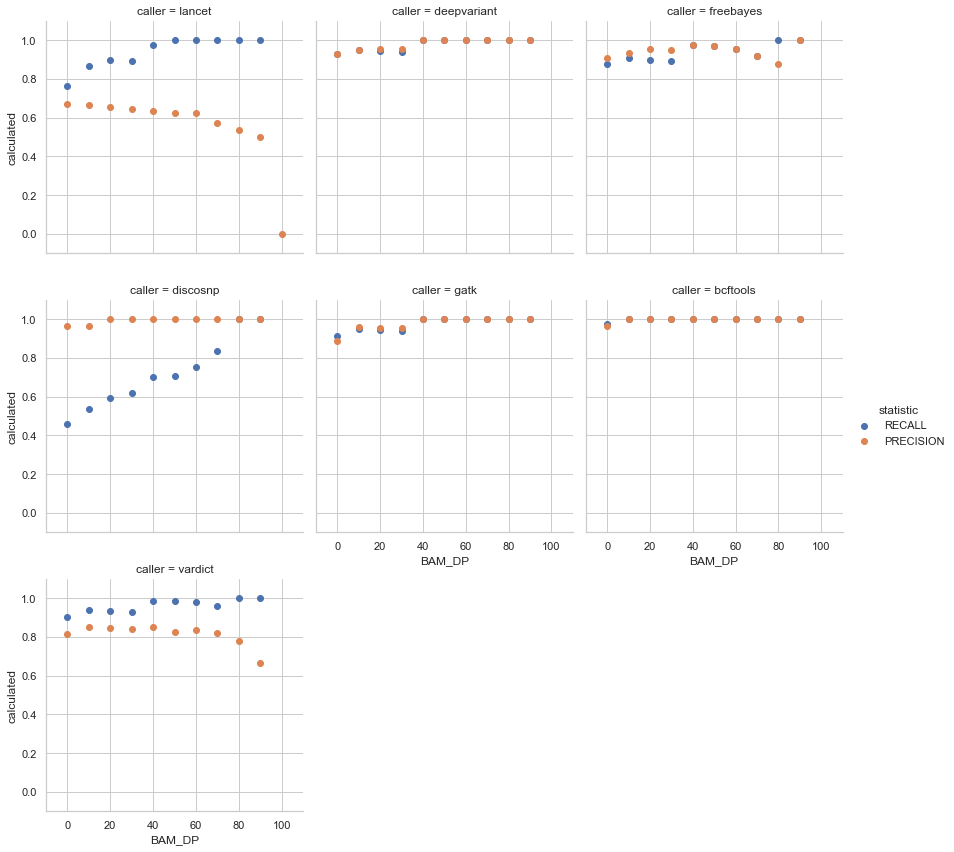

In [20]:
h37ra_toRv_recall = h37ra_toRv_summary.drop(['precision', 'total_mut_intro', 'total_mut_postfilter'], axis = 1)
h37ra_toRv_recall.rename(columns={'recall': 'calculated'}, inplace=True)
h37ra_toRv_recall['statistic'] = 'RECALL'
h37ra_toRv_precision = h37ra_toRv_summary.drop(['recall', 'total_mut_intro', 'total_mut_postfilter'], axis = 1)
h37ra_toRv_precision.rename(columns={'precision': 'calculated'}, inplace=True)
h37ra_toRv_precision['statistic'] = 'PRECISION'

h37ra_toRv_reshaped = pd.concat([h37ra_toRv_recall, h37ra_toRv_precision], ignore_index=True)

# Plot
sns.set(style='whitegrid')
fg = sns.FacetGrid(data=h37ra_toRv_reshaped, height=4, aspect=1, xlim=(-10,110), ylim=(-0.1,1.1), 
                   col='caller', col_wrap=3, hue='statistic')
fg.map(plt.scatter, 'BAM_DP', 'calculated').add_legend()

## In-house sequenced reads (H37Ra mapped to H37Ra-CP016972)

In [21]:
h37ra_toRA = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/sequenced/output/checked/sub1089-710-517_alltools_normalized_dp0_H37Ra_checked.csv')

In [22]:
h37ra_toRA

,CHROM,POS,REF,ALT,TYPE,INS_TYPE,LEN,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
0,CP016972.1,19261,G,A,SNP,NaN,1,1369.00,0,51,51,58,1,hom,NaN,gatk,sub1089-710-517,0,1,0
1,CP016972.1,1859086,A,AG,INS,NaN,1,1595.97,2,51,53,86,1,hom,NaN,gatk,sub1089-710-517,0,1,0
2,CP016972.1,2048178,T,C,SNP,NaN,1,1374.00,0,43,43,48,1,hom,NaN,gatk,sub1089-710-517,0,1,0
3,CP016972.1,19261,G,A,SNP,NaN,1,228.28,3,39,42,58,1/1,hom,NaN,bcftools,sub1089-710-517,0,1,0
4,CP016972.1,352324,T,C,SNP,NaN,1,4.48,12,6,18,32,0/1,het,NaN,bcftools,sub1089-710-517,0,1,0
5,CP016972.1,576277,T,G,SNP,NaN,1,7.22,29,12,41,54,0/1,het,NaN,bcftools,sub1089-710-517,0,1,0
6,CP016972.1,1095237,A,G,SNP,NaN,1,5.78,6,1,7,9,0/1,het,NaN,bcftools,sub1089-710-517,0,1,0
7,CP016972.1,1240245,A,C,SNP,NaN,1,7.82,19,11,30,36,0/1,het,NaN,bcftools,sub1089-710-517,0,1,0
8,CP016972.1,1543790,C,A,SNP,NaN,1,9.00,0,1,1,1,1/1,hom,NaN,bcftools,sub1089-710-517,0,1,0
9,CP016972.1,1859086,A,AG,INS,NaN,1,228.18,14,57,71,86,1/1,hom,NaN,bcftools,sub1089-710-517,0,1,0


In [23]:
h37ra_toRA_genomecov = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/sequenced/output/variants/sub1089-710-517_deduped_mq10_genomecov.bed', sep='\t', header=None)
h37ra_toRA_genomecov.rename(columns={0:'chrom', 1:'chromStart', 2:'chromEnd', 3:'coverage'}, inplace=True)

In [24]:
# Average read depth
h37ra_toRA_genomecov.coverage.mean()

69.48792009377223

In [25]:
# Zero coverage
h37ra_toRA_genomecov[h37ra_toRA_genomecov.coverage == 0]

,chrom,chromStart,chromEnd,coverage
6013,CP016972.1,13976,14496,0
6015,CP016972.1,14646,14715,0
46013,CP016972.1,105502,105574,0
147477,CP016972.1,337126,337221,0
147810,CP016972.1,338349,338358,0
...,...,...,...,...
1699700,CP016972.1,3963665,3963791,0
1699773,CP016972.1,3964292,3964385,0
1744878,CP016972.1,4067778,4067971,0
1832863,CP016972.1,4267864,4268454,0


## In-house sequenced reads (H37Ra mapped to H37Ra-inhouse)

In [95]:
h37ra_toINH = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/sequenced/output/checked/sub1089-710-517_alltools_normalized_dp0_H37Ra-inhouse_checked.csv')

In [96]:
h37ra_toINH

,CHROM,POS,REF,ALT,TYPE,INS_TYPE,LEN,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
0,CP016972.1,352324,T,C,SNP,NaN,1,4.48,12,6,18,32,0/1,het,NaN,bcftools,sub1089-710-517,0,1,0
1,CP016972.1,576277,T,G,SNP,NaN,1,7.22,29,12,41,54,0/1,het,NaN,bcftools,sub1089-710-517,0,1,0
2,CP016972.1,1095237,A,G,SNP,NaN,1,5.78,6,1,7,9,0/1,het,NaN,bcftools,sub1089-710-517,0,1,0
3,CP016972.1,1240245,A,C,SNP,NaN,1,7.82,19,11,30,36,0/1,het,NaN,bcftools,sub1089-710-517,0,1,0
4,CP016972.1,1543790,C,A,SNP,NaN,1,9.00,0,1,1,1,1/1,hom,NaN,bcftools,sub1089-710-517,0,1,0
5,CP016972.1,2023201,T,G,SNP,NaN,1,6.45,27,10,39,60,0/1,het,NaN,bcftools,sub1089-710-517,0,1,0
6,CP016972.1,2237936,C,CG,INS,NaN,1,16.69,26,6,32,35,0/1,het,NaN,bcftools,sub1089-710-517,0,1,0
7,CP016972.1,2561954,T,C,SNP,NaN,1,3.22,0,1,1,1,1/1,hom,NaN,bcftools,sub1089-710-517,0,1,0
8,CP016972.1,2603410,T,G,SNP,NaN,1,18.92,29,14,43,53,0/1,het,NaN,bcftools,sub1089-710-517,0,1,0
9,CP016972.1,2815099,A,C,SNP,NaN,1,6.90,22,11,34,44,0/1,het,NaN,bcftools,sub1089-710-517,0,1,0


## In-house sequenced reads (H37Ra mapped to H37Ra-INHOUSE-SNP10-3)

**VarDict results not included yet**

# Variant Synthesis

## H37Rv-based datasets

These datasets are completely synthesized `in silico`. I used `variants.py` to introduce SNPs or indels at a density of 1 every 1,000 bp into the *M. tuberculosis* H37Rv reference genome (NC_000962.3), and generate variant whole genome sequences. I then used `art_illumina` to synthesize paired-end reads based on the created variant genomes:

- H37Rv10-3SNP: 4364 SNPs only
- H37Rv10-3INS: 4401 insertions only (2204 duplications + 1089 random-sequence insertions + 1108 inversions)
- H37Rv10-3DEL: 4285 deletions only
- H37Rv10-3IND1 (not included in this notebook): 4317 indels (1119 duplications + 524 random-sequence insertion + 558 inversions + 2116 deletions)

## In-house H37Ra-based datasets

The reference genome, *H37Ra-inhouse*, was created by introducing 4 polymorphisms into H37Ra (CP016972.1) with `variants.py`. These 4 polymorphisms were identified by mapping in-house sequenced reads of Salipante lab *M. tuberculosis* ATCC strain to CP016972.1 and manually checking called polymorphisms with IGV.

I then used `variants.py` to synthesize divergent genomes based on the above reference, and mapped the in-house sequenced ATCC reads to these divergent genomes. **This allows us to test the variant callers using real reads, and still have a truth set of mutations from the synthesized divergent genomes.**

(I remembered too late that I could have used the draft genome assembled from the same reads with the Salipante lab DNAASI pipeline, as the initial reference genome.)

- H37Ra-INHOUSE-SNP10-3: 4421 SNPs only
- H37Ra-INHOUSE-INS10-3: 4455 insertions only (2244 duplications + 1130 random-sequence insertions+ 1081 inversions)
- H37Ra-INHOUSE-DEL10-3: 4321 deletions only


# Validation of variant synthesis

## Reference and variant genome alignments

mauve?

In [74]:
# Reference genome
with open('/Users/yeemayseah/Documents/Repos/mtb_amr/data/GCF_000195955.2_ASM19595v2_genomic.fna') as fa:
    ref_fa = fa.readlines()
    ref = ''
    for lines in ref_fa[1:]:
        ref += lines.rstrip()

# Variant genome
with open('/Users/yeemayseah/Documents/Repos/mtb_amr/output/variants/H37Rv10-3SNP.fa', 'r') as inputfa:
    snp1k_fa = inputfa.readlines()[1]

# Mutation list
snp1klist = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/variants/H37Rv10-3SNP.txt', sep='\t')
snp1klist.head()

,#CHROM,POS,ID,REF,ALT,TYPE,INS_TYPE
0,NC_000962.3,844,.,A,G,SNP,NaN
1,NC_000962.3,2677,.,A,G,SNP,NaN
2,NC_000962.3,4316,.,C,G,SNP,NaN
3,NC_000962.3,5666,.,G,A,SNP,NaN
4,NC_000962.3,6403,.,T,C,SNP,NaN


In [71]:
print(ref[843], ref[2676], ref[4315], ref[5665], ref[6402])
print(snp1k_fa[843], snp1k_fa[2676], snp1k_fa[4315], snp1k_fa[5665], snp1k_fa[6402])

A A C G T
G G G A C


In [70]:
snp1klist.tail()

,#CHROM,POS,ID,REF,ALT,TYPE,INS_TYPE
4359,NC_000962.3,4405635,.,C,G,SNP,NaN
4360,NC_000962.3,4406429,.,A,C,SNP,NaN
4361,NC_000962.3,4408076,.,T,C,SNP,NaN
4362,NC_000962.3,4409506,.,G,T,SNP,NaN
4363,NC_000962.3,4410737,.,C,A,SNP,NaN


In [73]:
print(ref[4405634], ref[4406428], ref[4408075], ref[4409505], ref[4410736])
print(snp1k_fa[4405634], snp1k_fa[4406428], snp1k_fa[4408075], snp1k_fa[4409505], snp1k_fa[4410736])

C A T G C
G C C T A


## Synthetic Reads

ART was used to simulate reads based on the reference and variant genomes, with the following parameters:

In [79]:
# Distribution of simulated read lengths per dataset

## Read Mapping and Depths
Reads with MAPQ < 10 are removed.

In [120]:
# Read depth across genomes
snp1k_perbase_cov = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/mapped/H37Rv10-3SNP_trimmed-sorted_perbase-genomecov.txt', sep='\t', header=None)
ins1k_perbase_cov = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/mapped/H37Rv10-3INS_trimmed-sorted_perbase-genomecov.txt', sep='\t', header=None)
del1k_perbase_cov = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/mapped/H37Rv10-3DEL_trimmed-sorted_perbase-genomecov.txt', sep='\t', header=None)

In [121]:
snp1k_perbase_cov.rename(columns={1:'pos', 2:'depth'}, inplace=True)
ins1k_perbase_cov.rename(columns={1:'pos', 2:'depth'}, inplace=True)
del1k_perbase_cov.rename(columns={1:'pos', 2:'depth'}, inplace=True)

<AxesSubplot:xlabel='pos'>

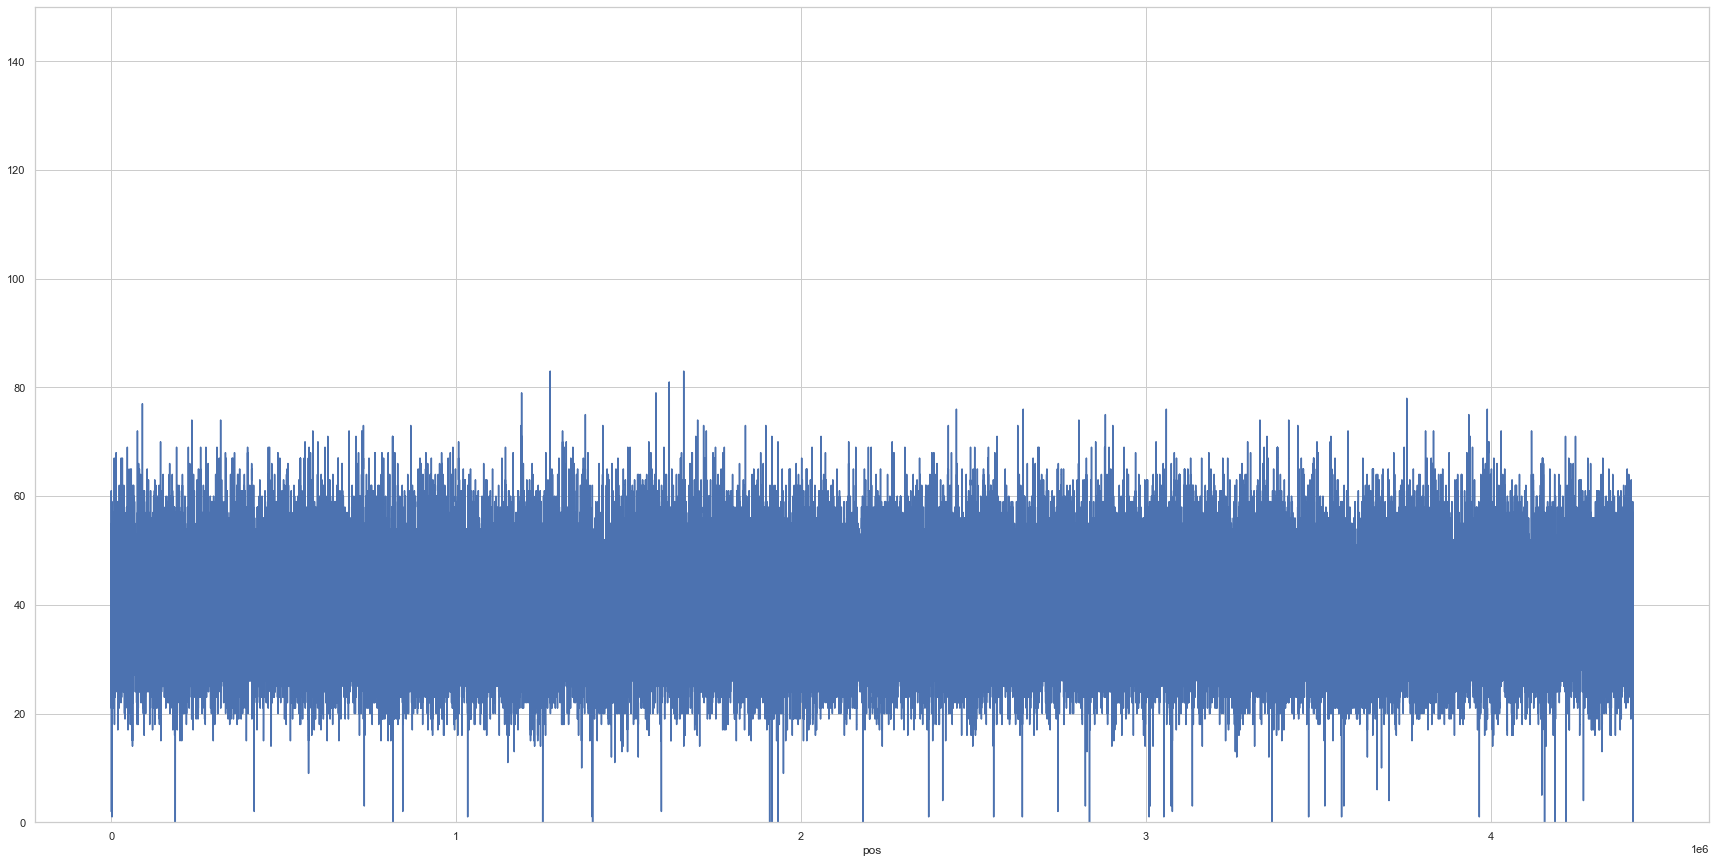

In [122]:
snp1k_perbase_cov.plot(x='pos', y='depth', kind='line', legend=False, figsize=(30,15), ylim=(0,150))

<AxesSubplot:xlabel='pos'>

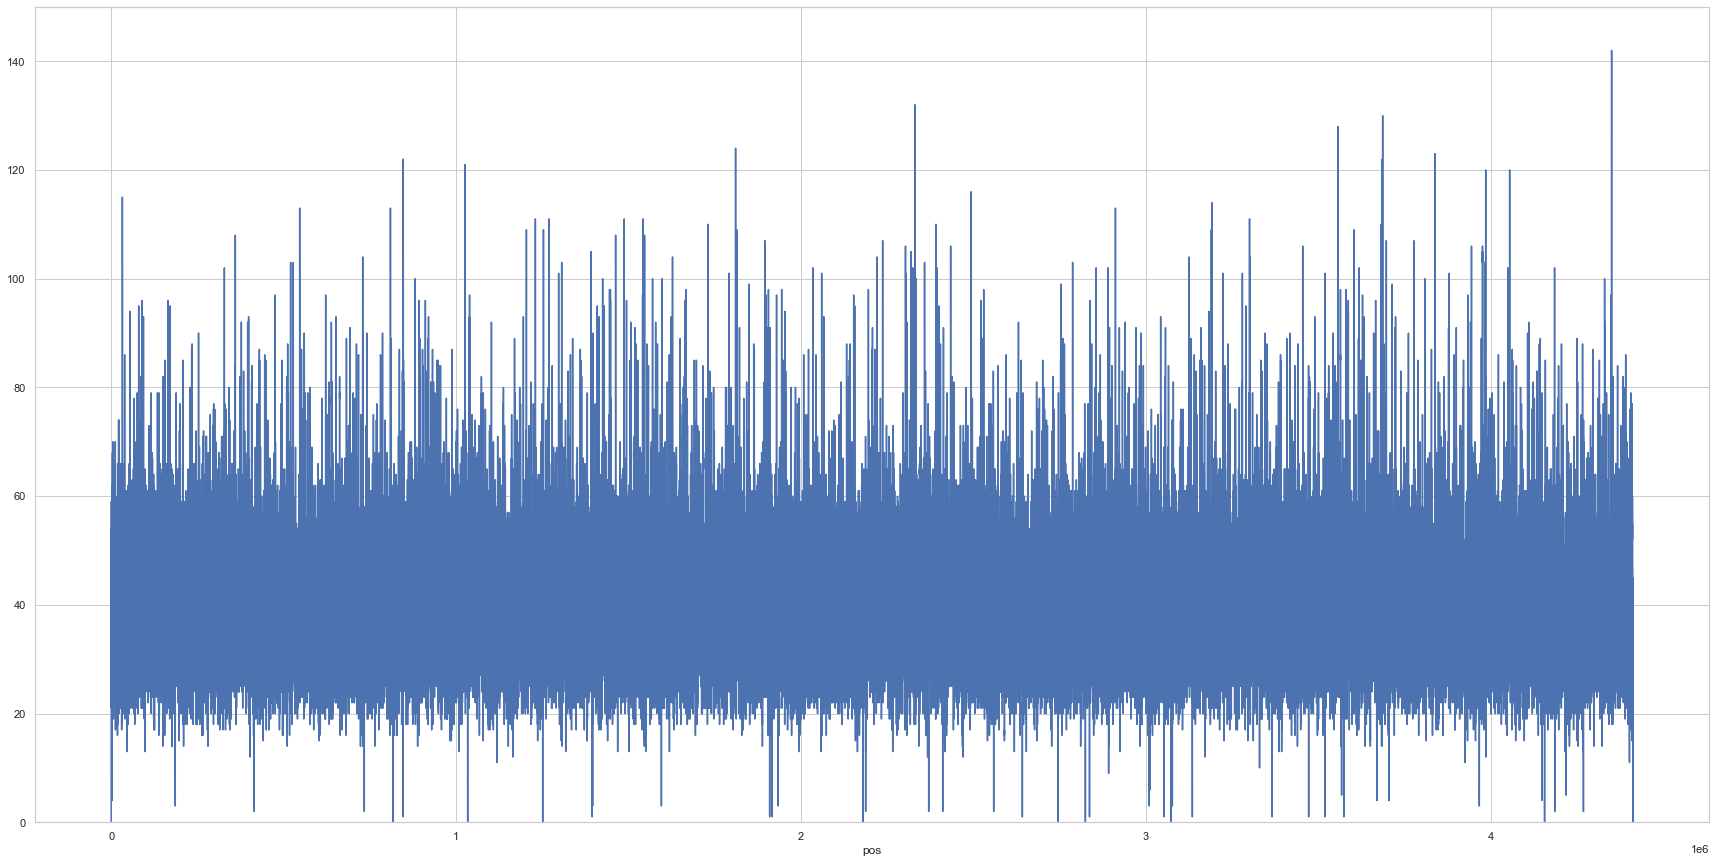

In [123]:
ins1k_perbase_cov.plot(x='pos', y='depth', kind='line', legend=False, figsize=(30,15), ylim=(0,150))

<AxesSubplot:xlabel='pos'>

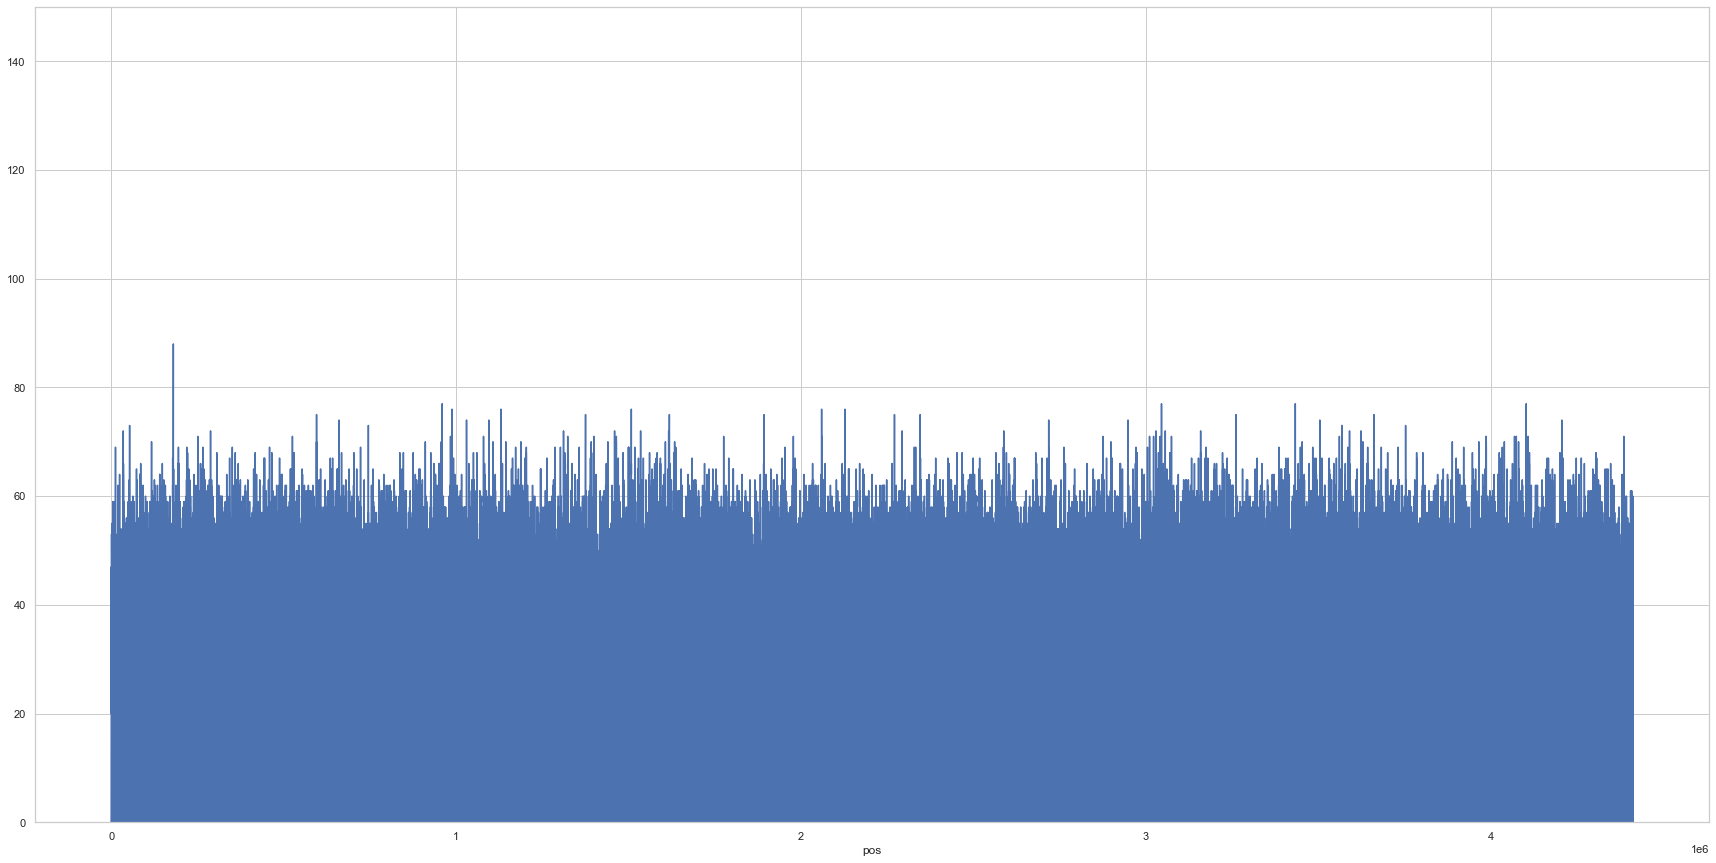

In [124]:
del1k_perbase_cov.plot(x='pos', y='depth', kind='line', legend=False, figsize=(30,15), ylim=(0,150))

In [76]:
# Mapping quality across genomes